# Рекуррентная нейронная сеть для генерации текста

In [2]:
import numpy as np
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt

проверка, можно ли использовать GPU

In [30]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

загрузка текста, не забудьте указать пути к файлам

In [97]:
#filename = "crimeAndPunishment.txt"
#filename = "Nosov.txt"
filename = "Alice.txt"
text = open(filename).read()
#text = open(filename, 'r', encoding='utf-8').read() - for russian
text = text.lower()
text = text.replace("\n", " ")

создаем словарь символов

In [98]:
chars = sorted(list(set(text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
n_chars = len(text)
n_vocab = len(chars)
print ("Total Characters: ", n_chars)
print ("Total Vocab: ", n_vocab)

Total Characters:  144309
Total Vocab:  42


подготовка датасета, нормализация

In [99]:
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

X = np.reshape(dataX, (n_patterns, seq_length, 1))
X = X / float(n_vocab)
y = np_utils.to_categorical(dataY)

Total Patterns:  144209


функция для мягкой генерации с использованием температуры

In [111]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

добаление чекпойнтов 

In [101]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

определяем модель рекурентной нейронной сети

In [102]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 256)          394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 42)               

обучение нейросети

In [147]:
history = model.fit(X, y, epochs=8, batch_size=128, callbacks=callbacks_list)

Epoch 1/8
1127/1127 [==============================] - 50s 44ms/step - loss: 0.9064

Epoch 00001: loss improved from 0.91002 to 0.90636, saving model to weights-improvement-01-0.9064.hdf5
Epoch 2/8
1127/1127 [==============================] - 50s 45ms/step - loss: 0.9039

Epoch 00002: loss improved from 0.90636 to 0.90388, saving model to weights-improvement-02-0.9039.hdf5
Epoch 3/8
1127/1127 [==============================] - 50s 45ms/step - loss: 0.8994

Epoch 00003: loss improved from 0.90388 to 0.89940, saving model to weights-improvement-03-0.8994.hdf5
Epoch 4/8
1127/1127 [==============================] - 50s 45ms/step - loss: 0.8931

Epoch 00004: loss improved from 0.89940 to 0.89315, saving model to weights-improvement-04-0.8931.hdf5
Epoch 5/8
1127/1127 [==============================] - 51s 45ms/step - loss: 0.8938

Epoch 00005: loss did not improve from 0.89315
Epoch 6/8
1127/1127 [==============================] - 51s 45ms/step - loss: 0.8888

Epoch 00006: loss improved from

графики обучения

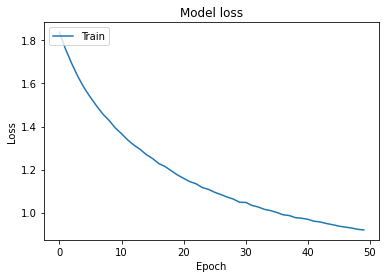

In [105]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

подгрузка модели по записанному чекпойнту

In [11]:
filename = "weights-improvement-50-1.4621.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

генерация

In [152]:
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start].copy()
temperature = 0.01
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(300):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    #prediction = model.predict(x, verbose=0)[0]
    #index = sample(prediction, temperature)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print('...')

Seed:
" to a tidy little room with a table in the window, and on it (as she had hoped) a fan and two or thre "
e dares of the court.  'that was that in the sea,' the mock turtle seplied. 'it's very curinus,'  the mouse was sitting on the sop of her head inpatiently, and she went on again:--  'i haven't the shing,' said the mock turtle. ''not i!' alice replied in a tone of great curiosity.  'i should like to ...


Вывод: структура самого текста похожа на настоящий, практически все слова написаны правильно. Но смысла в сгенерированном тексте нет.